### DATA 512: Human Centered Data Science
#### A2: Bias in Data | Author: Aboli Moroney | 15-Oct-2020

#### Motivation: The goal of this notebook is to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.  

This notebook performs an exploratory analysis to uncover the biases in the Aggression and Toxicity data sets in Wikipedia Talk project on Figshare. The source data includes:

- **Aggression**: 100k labeled comments from English Wikipedia by approximately 10 annotators via Crowdflower on how aggressive the comment was perceived to be along with some demographic data for each crowd-worker.

- **Toxicity**: 160k labeled comments from English Wikipedia by approximately 10 annotators via Crowdflower on a spectrum of how toxic the comment is (perceived as likely to make people want to leave the discussion) to how healthy to conversation the contribution is.


Source data for the analysis can be found [on Figshare](https://figshare.com/projects/Wikipedia_Talk/16731) and the schema and descriptions can be found [here](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release).

This block of code is used to import the different Python libraries that we will use throughout our analysis.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from  matplotlib.ticker import PercentFormatter


Next, we will read the raw data files for both aggression and toxicity. Each contains 3 types of files:

1. Comments - contains the comments in the wikipedia pages and the revisions
2. Annotations - contains annotations labeled by several crowdworkers for each comment in the above file
3. Worker Demographics - contains demographic information of the annotators like their age group, gender, education and fluency in english language

We will do some preliminary data cleaning such as removal of the newline and tab tokens from comments.

In [2]:
# Read the source data for Aggression and Toxicity (comments, annotated comments and worker demographics)

agg_comments = pd.read_csv('../1-Data/data_aggression_annotated_comments.tsv', sep = '\t')
agg_annotations = pd.read_csv('../1-Data/data_aggression_annotations.tsv',  sep = '\t')
agg_demographics = pd.read_csv('../1-Data/data_aggression_worker_demographics.tsv',  sep = '\t')

tox_comments = pd.read_csv('../1-Data/data_toxicity_annotated_comments.tsv', sep = '\t')
tox_annotations = pd.read_csv('../1-Data/data_toxicity_annotations.tsv',  sep = '\t')
tox_demographics = pd.read_csv('../1-Data/data_toxicity_worker_demographics.tsv',  sep = '\t')

# Remove newline and tab tokens from comments

agg_comments['comment'] = agg_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
agg_comments['comment'] = agg_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
tox_comments['comment'] = tox_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))


Now we will perform some quick quality checks to see the number of unique comments in the aggression and toxicity raw data files. We should expect approximately 100k comments in the aggression files and 160k comments in the toxicity files based on the file description in [wikimedia](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release)

In [3]:
# Quality checks

print(len(agg_annotations['rev_id'].unique()), len(agg_comments['rev_id'].unique())) 
print(len(tox_comments['rev_id'].unique()), len(tox_annotations['rev_id'].unique())) 


115864 115864
159686 159686


Now we will merge the comments, annotations and worker demographics to create a single master data set for analysis.

In [4]:
# Join the 3 datasets to create a master dataset for analysis for both Aggression and Toxicity

agg_df = pd.merge(agg_annotations, agg_comments, how='left', on=['rev_id']) #get comment details
agg_df = pd.merge(agg_df, agg_demographics, how='left', on=['worker_id']) #get worker details

tox_df = pd.merge(tox_annotations, tox_comments, how='left', on=['rev_id']) #get comment details
tox_df = pd.merge(tox_df, tox_demographics, how='left', on=['worker_id']) #get worker details

agg_df.head(3) #view the master file to understand the structure

rev_id  worker_id  aggression  aggression_score  \
0   37675       1362         1.0              -1.0   
1   37675       2408         0.0               1.0   
2   37675       1493         0.0               0.0   

                                             comment  year  logged_in  \
0  `- This is not ``creative``.  Those are the di...  2002       True   
1  `- This is not ``creative``.  Those are the di...  2002       True   
2  `- This is not ``creative``.  Those are the di...  2002       True   

        ns  sample  split  gender  english_first_language age_group  education  
0  article  random  train    male                     0.0     18-30    masters  
1  article  random  train    male                     1.0     30-45         hs  
2  article  random  train  female                     0.0     30-45  bachelors

### Analysis 1: Analyze the demographic information about the Crowdflower workers that is available in the dataset

#### Research Questions
1. Is there fair representation of the different genders (male, female, other) in demographic profile of the crowdworkers who are labelling the comments as aggressive or toxic? Do they fairly to represent the the general population? 
2. Are the comments are being distributed evenly across different genders (male, female and other) for a fair labelling exercise?

#### Exploratory Analysis

1. The distribution of workers by gender who are labelling the comments datasets 
2. The distribution of comments annotated by gender of the annotators 

The code chunk below compares the number of workers across different genders for both Toxicity and Aggression data sets.
It also compare the number of comments reviews by workers of different genders.The outputs are displayed in a table as well as  bar graphs for easy comparison. The bar graphs are saved as .png files in the Outputs directory for future reference.

Type  gender  workers_count  comments_reviewed
0  Aggression  female            840             308103
1  Aggression    male           1349             547328
2  Aggression   other              1                 83
3    Toxicity  female           1263             457346
4    Toxicity    male           2327             889251
5    Toxicity   other              1                358

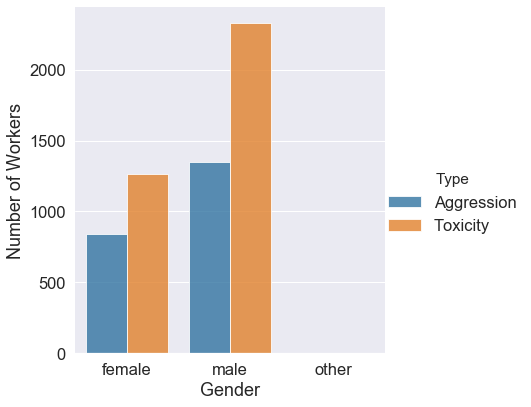

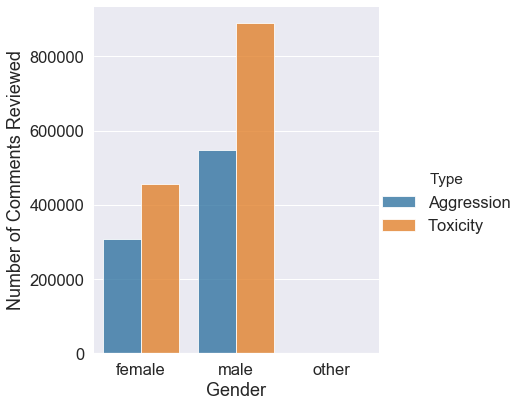

In [5]:
# Calculate number of workers by gender 

agg_gender_workers = agg_demographics.groupby(['gender']).worker_id.agg('count').to_frame('workers_count').reset_index()
agg_gender_workers['Type'] = "Aggression"
tox_gender_workers = tox_demographics.groupby(['gender']).worker_id.agg('count').to_frame('workers_count').reset_index()
tox_gender_workers['Type'] = "Toxicity"
gender_workers = agg_gender_workers.append(tox_gender_workers)

# Calculate number of comments reviewed by gender

agg_gender_comments = agg_df.groupby(['gender']).rev_id.agg('count').to_frame('comments_reviewed').reset_index()
agg_gender_comments['Type'] = "Aggression"
tox_gender_comments = tox_df.groupby(['gender']).rev_id.agg('count').to_frame('comments_reviewed').reset_index()
tox_gender_comments['Type'] = "Toxicity"
gender_comments = agg_gender_comments.append(tox_gender_comments)

# Merge the comments and no of workers counts

distribution_gender = pd.merge(gender_workers, gender_comments, how='outer', on=['gender', 'Type']) 

# Tablular Output

distribution_gender = distribution_gender[['Type', 'gender', 'workers_count', 'comments_reviewed']]
display(distribution_gender) #view the output

# Bar Chart Outputs

sns.set_style('ticks')
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.5)  

g = sns.catplot(
    data=distribution_gender, kind="bar",
    x="gender", y="workers_count", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Gender", "Number of Workers")

g2 = sns.catplot(
    data=distribution_gender, kind="bar",
    x="gender", y="comments_reviewed", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g2.despine(left=True)
g2.set_axis_labels("Gender", "Number of Comments Reviewed")

# Save Outputs

g.savefig("../3-Outputs/Analysis1_WorkersbyGender.png")
g2.savefig("../3-Outputs/Analysis1_CommentsReviewedbyGender.png")


#### Observations and Potential Implications:

1. The distribution of workers by gender is not does not represent the general population fairly. The number of male annotators is much higher than female annotators in both aggression and toxicity worker demographic datasets. Further, there is only 1 annotator in who is of the gender 'other' (neither male nor female). This unequal distribution of workers is likely to introduce a gender bias in the labelling process. The way men, women and transgender (other) percieve comments can be different and thus there should be equal or proportionate representation of all 3 in the workers datasets.
<br><br>
2. We further see that the number of comments reviewed by male, female and other gender annotators is also disproportionate. Males reviewed the highest number of comments followed by females. The comments reviewed by 'other' gender workers are negligible compared to males and females. This is further evidence that there could be gender bias in the labelling process as it is not evenly distributed.



### Analysis 2: Explore relationships between worker age groups and labeling behavior

#### Research Questions
1. Is there fair representation of the annotators across all age groups? 
2. Are younger labelers more or less likely to label comments as aggressive or toxic than older labelers?


#### Exploratory Analysis
To answer the above questions, we will analyze the following

1. The distribution of workers by age groups who are labelling the comments datasets 
2. The percentage of comments by workers across different age groups that have been labelled as aggressive/toxic

The code chunk below calculates the number of workers across different age groups for both Toxicity and Aggression data sets.
The outputs are displayed in a table as well as a bar graph for comparison. The bar graph is saved as a .png file in the Outputs directory for future reference.

Type       Aggression Data Annotators  Toxicity Data Annotators
age_group                                                      
0-18                               37                        79
18-30                            1049                      1862
30-45                             831                      1247
45-60                             218                       296
Over 60                            20                        30

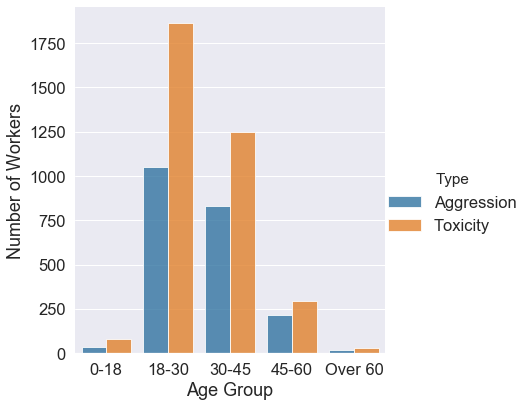

In [6]:
# Calculate number of workers by age group

agg_age_workers = agg_demographics.groupby(['age_group']).worker_id.agg('count').to_frame('workers_count').reset_index()
agg_age_workers['Type'] = "Aggression"

tox_age_workers = tox_demographics.groupby(['age_group']).worker_id.agg('count').to_frame('workers_count').reset_index()
tox_age_workers['Type'] = "Toxicity"

age_workers = agg_age_workers.append(tox_age_workers)
age_workers = age_workers.replace(['Under 18'], '0-18')
age_workers = age_workers.sort_values(['age_group'])

# Tabular Output

age_workers_table = pd.pivot_table(age_workers, values='workers_count', index=['age_group'],
                    columns=['Type'], aggfunc=np.sum)
age_workers_table = age_workers_table.rename(columns={ "Aggression": "Aggression Data Annotators", 
                                                        "Toxicity" : "Toxicity Data Annotators" })
display(age_workers_table)

# Bar Chart Output

sns.set_style('ticks')
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.5)  

g = sns.catplot(
    data=age_workers, kind="bar",
    x="age_group", y="workers_count", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Age Group", "Number of Workers")

# Save Output

g.savefig("../3-Outputs/Analysis2_WorkersbyAge.png") 


#### Observations and Potential Implications:

- The distribution of workers by age groups is not does not represent the general population fairly. 
- The number of annotators between ages 18 to 30 is the highest, followed by ages 30 to 45, and 45 to 60. 
- The number of non-adult annotators (below 18) and senior annotators (above 60) are much lower to the mid age group annotators.
- The unequal distribution of workers is likely to introduce an age bias in the labelling process and bias the training for machine learning models as well to be skewed towards the age groups 18 to 45. 
- The comments that the youth may find aggressive/toxic may be percieved differently by older readers and even children. 
- Hence, there should be a fair distribution of annotators across all age groups to represent the general population.

Now let us look at the percentage of comments that annotators across different age groups labelled as aggressive or toxic.

The code chunk below calculates the % comments labelled as aggressive or toxic by workers across different age groups. The outputs are displayed in a table as well as a bar graph for comparison. The bar graph is saved as a .png file in the Outputs directory for future reference. 

Type        % Aggressive Comments  % Toxic Comments
age_group_                                         
0-18                         13.1              12.0
18-30                        16.8              14.1
30-45                        19.0              14.9
45-60                        23.6              16.6
Over 60                      23.7              15.7

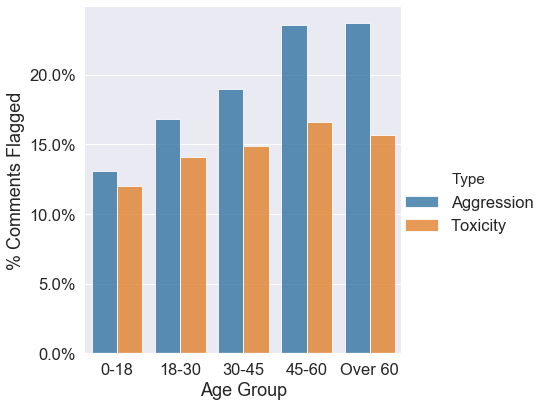

In [7]:
# % Comments of flagged for aggession and toxicity by age_group

agg_age_comments = agg_df.groupby('age_group', as_index=False).agg(
    {'aggression':['sum', 'count']})
agg_age_comments.columns = ["_".join(x) for x in agg_age_comments.columns.ravel()]
agg_age_comments['Percentage'] = round(agg_age_comments['aggression_sum']/agg_age_comments['aggression_count'], 3) 
agg_age_comments['Type'] = "Aggression"
#display(agg_age_comments) #QC

tox_age_comments = tox_df.groupby('age_group', as_index=False).agg(
    {'toxicity':['sum', 'count']})
tox_age_comments.columns = ["_".join(x) for x in tox_age_comments.columns.ravel()]
tox_age_comments['Percentage'] = round(tox_age_comments['toxicity_sum']/tox_age_comments['toxicity_count'], 3) 
tox_age_comments['Type'] = "Toxicity"
#display(tox_age_comments) #QC

# Merge the above 2 tables for plotting
comments_flagged_age = agg_age_comments.append(tox_age_comments)
comments_flagged_age = comments_flagged_age.replace(['Under 18'], '0-18')
comments_flagged_age = comments_flagged_age.sort_values(['age_group_'])
#display(comments_flagged_age) # view table

# Tabular Output

age_comments_table = pd.pivot_table(comments_flagged_age, values='Percentage', index=['age_group_'],
                    columns=['Type'], aggfunc=np.sum)
age_comments_table['Aggression'] = (100*age_comments_table['Aggression'])
age_comments_table['Toxicity'] = 100*age_comments_table['Toxicity']
age_comments_table = age_comments_table.rename(columns={ "Aggression": "% Aggressive Comments", 
                                                        "Toxicity" : "% Toxic Comments" })
display(age_comments_table)

# Bar Chart Output

sns.set_style('ticks')
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.5)  

g = sns.catplot(
    data=comments_flagged_age, kind="bar",
    x="age_group_", y="Percentage", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Age Group", "% Comments Flagged")

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
# Save Output

g.savefig("../3-Outputs/Analysis2_PercentCommentsbyAge.png") 


#### Observations and Potential Implications:

- The percentage of comments flagged as aggressive goes on increasing from 13% to 24% as the age of the annotators increases. This may be an indication that older age groups might be more sensitive to aggressive language compared to younger annotators which may introduce bias in the labelling process.

- The percentage of comments flagged as toxic does not vary as significantly across agre groups. They range between 12% to 17%. This is a likely indication that the bias in labelling comments as toxic across age groups may is not as extreme as aggressive comments.

- However, it is important to note that there is a difference in the perception of toxicity and aggression across age groups which is likely to introduce bias while training models as well.

### Step 2: Discuss further implications


**Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?**

I feel that the 'Create tools for commenters' application shown on the [Perspective API home page](https://www.perspectiveapi.com/#/home) could perform well and be a useful tool. It givesr real time feedback to the commentor on whether the comment could be perceived as toxic or not using a % toxicity score and allows the user to self-correct.
I think a tool like this will force users to think again before posting toxic content. Even if the score is not absolutely accurate, it will guide the commentor to be more choiceful about their language. Taking action before a comment is posted is definitely a good preventative measure than filtering it after it has been published.


**What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?**

Comments on Wikipedia are free text and similar to posts that are posted on social media platforms like Twitter, Facebook, Instagram, etc. I believe that the models used in this API could also perform fairly well if they are used to detect toxicity, aggression and personal attacks on these platforms. I also believe that this could be extended to newspapers and journalism where we measure the articles before they get published.


**What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models?**

Speeches/comments that are posted in another language but using english script (alphabet) would be hard for Perspective API to detect and get trained on. The reason is that these words are not a part of the english dictionary and would be hard to identify or classify as a part of speech. Aditionally, the spelling of such words may be very subjective to the person who is typing and could be hard to train the model on multiple variations of these sentences or words. Such comments can be negative or hateful and may go undetected.
